In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [2]:
data = pd.read_csv("mushroom.csv")
print(data.head())

  class  cap-diameter cap-shape cap-surface cap-color does-bruise-or-bleed  \
0     p         15.26         x           g         o                    f   
1     p         16.60         x           g         o                    f   
2     p         14.07         x           g         o                    f   
3     p         14.17         f           h         e                    f   
4     p         14.64         x           h         o                    f   

  gill-attachment gill-spacing gill-color  stem-height  ...  stem-root  \
0               e          NaN          w        16.95  ...          s   
1               e          NaN          w        17.99  ...          s   
2               e          NaN          w        17.80  ...          s   
3               e          NaN          w        15.77  ...          s   
4               e          NaN          w        16.53  ...          s   

  stem-surface stem-color veil-type veil-color has-ring ring-type  \
0            y   

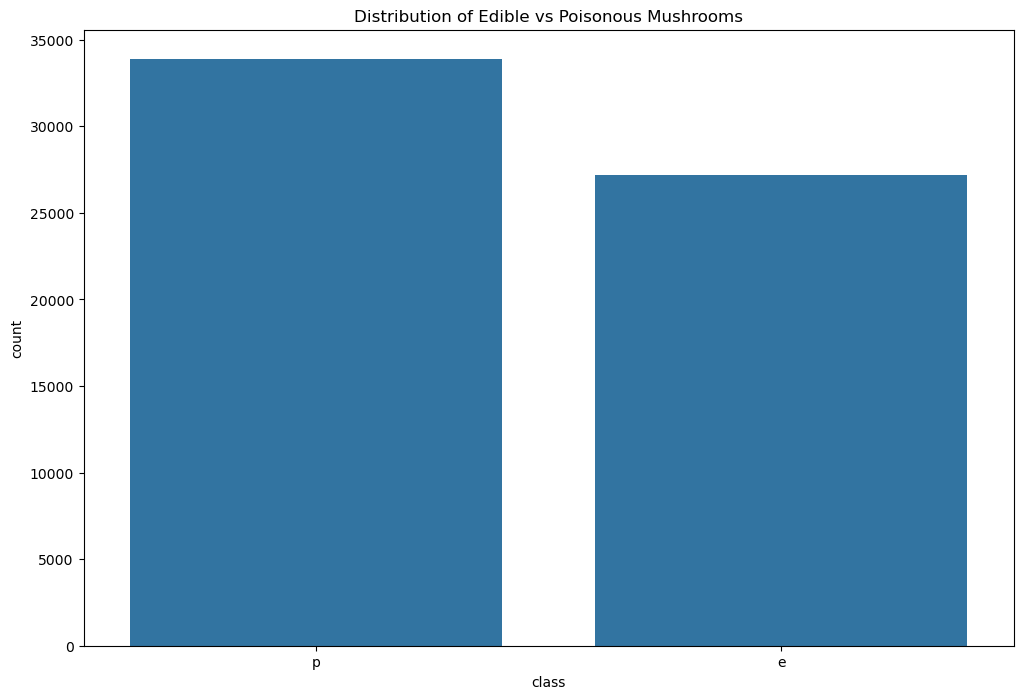

In [3]:
plt.figure(figsize=(12,8))
sns.countplot(x='class', data=data)
plt.title("Distribution of Edible vs Poisonous Mushrooms")
plt.show()

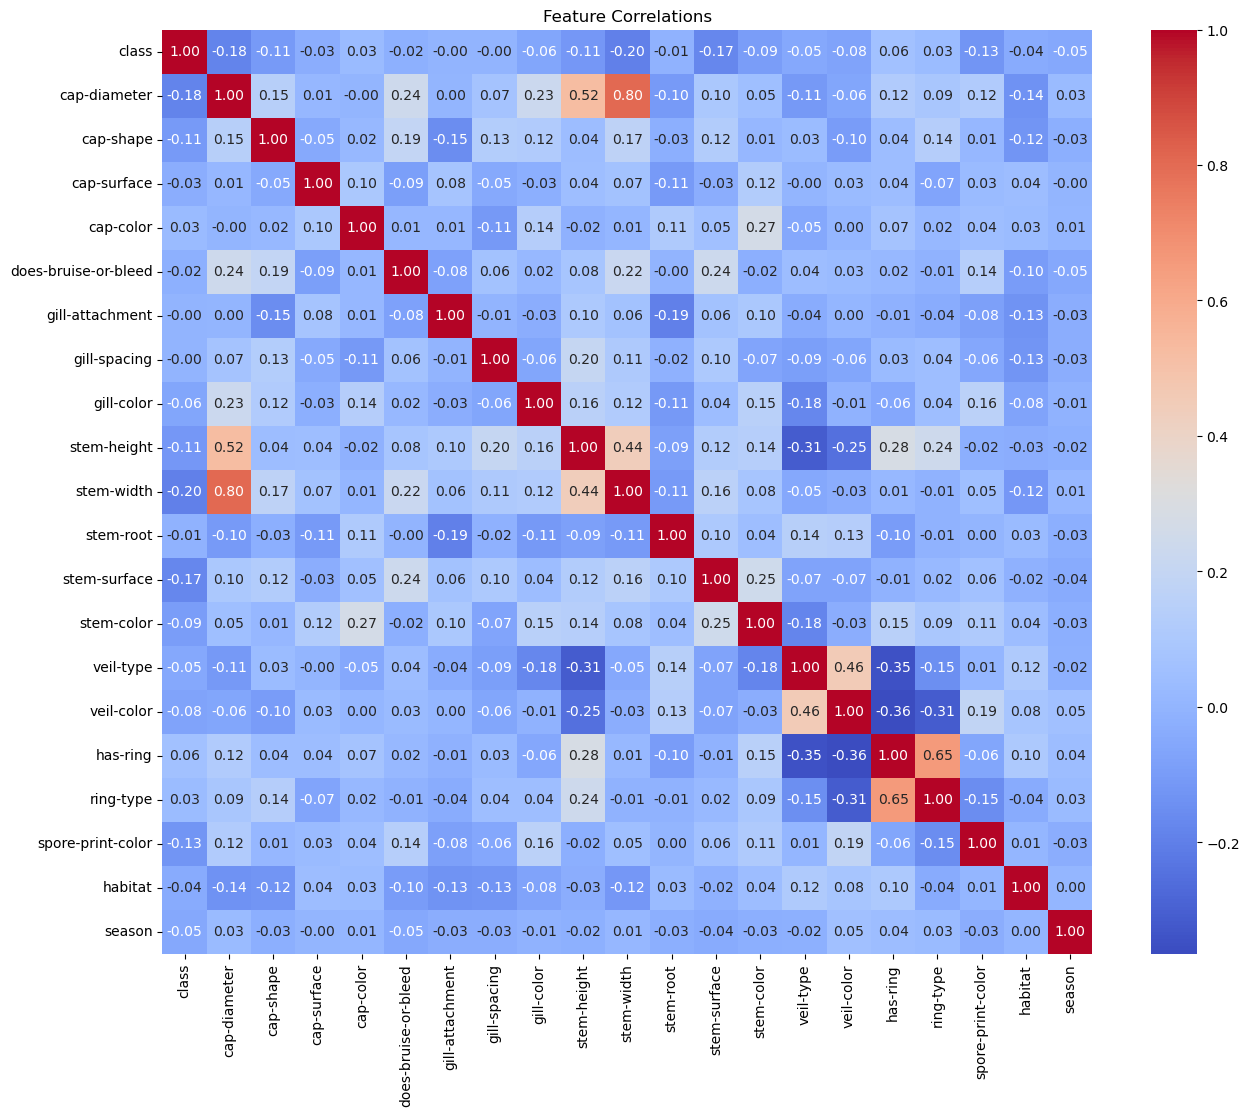

In [4]:
encoded_data = data.copy()
for col in encoded_data.columns:
    encoded_data[col] = LabelEncoder().fit_transform(encoded_data[col])

plt.figure(figsize=(15,12))
sns.heatmap(encoded_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

In [5]:
X = data.drop(['class', 'does-bruise-or-bleed', 'habitat', 'season'], axis=1)
y = data['class']

X_encoded = pd.get_dummies(X, drop_first=True)
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)  # 0 = edible, 1 = poisonous

mushroom_example = X_encoded.iloc[17303]
class_example = y_encoded[17303]

print("Feature row (X):")
print(mushroom_example.to_string())
print("\nTarget value (y):")
print(class_example)

Feature row (X):
cap-diameter            8.95
stem-height             7.67
stem-width             30.78
cap-shape_c            False
cap-shape_f             True
cap-shape_o            False
cap-shape_p            False
cap-shape_s            False
cap-shape_x            False
cap-surface_e          False
cap-surface_g          False
cap-surface_h          False
cap-surface_i          False
cap-surface_k          False
cap-surface_l          False
cap-surface_s           True
cap-surface_t          False
cap-surface_w          False
cap-surface_y          False
cap-color_e            False
cap-color_g            False
cap-color_k            False
cap-color_l            False
cap-color_n            False
cap-color_o            False
cap-color_p            False
cap-color_r            False
cap-color_u            False
cap-color_w             True
cap-color_y            False
gill-attachment_d      False
gill-attachment_e      False
gill-attachment_f      False
gill-attachment_p      Fal

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=7, shuffle=True
)

In [7]:
rf = RandomForestClassifier(n_estimators=200, random_state=7, class_weight='balanced')
rf.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)

In [9]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_y.classes_))

Classification Report:
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      5465
           p       1.00      1.00      1.00      6749

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214



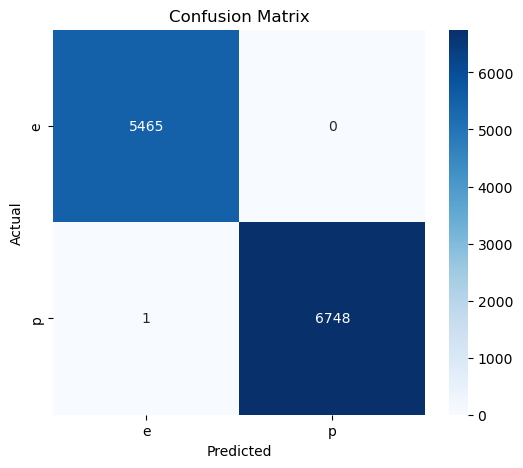

In [10]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [11]:
joblib.dump(rf, "mushroom_rf_model.pkl")
joblib.dump(le_y, "label_encoder.pkl")

['label_encoder.pkl']

In [12]:
def predict_mushroom(user_input):
    """
    user_input: dict of feature_name: value
    Example:
    user_input = {
        'cap-diameter'
        'cap-shape'
        'cap-surface'
        'cap-color'
        'gill-attachment'  
        'gill-spacing' 
        'gill-color'  
        'stem-height'
        'stem-width' 
        'stem-root'  
        'stem-surface'  
        'stem-color' 
        'veil-type' 
        'veil-color' 
        'has-ring'  
        'ring-type'
        'spore-print-color'
    }
    Returns: predicted class ('edible'/'poisonous') and probability %
    """
    
    input_df = pd.DataFrame([user_input])

    input_encoded = pd.get_dummies(input_df)

    missing_cols = set(rf.feature_names_in_) - set(input_encoded.columns)
    for col in missing_cols:
        input_encoded[col] = 0
    input_encoded = input_encoded[rf.feature_names_in_]

    prob = rf.predict_proba(input_encoded)[0]
    pred_index = np.argmax(prob)
    pred_class = le_y.classes_[pred_index]

    confidence = prob[pred_index] * 100

    return pred_class, round(confidence, 2)

In [13]:
pred_class, confidence = predict_mushroom(mushroom_example)
print(f"Prediction: {pred_class}, Confidence: {confidence}%")

Prediction: e, Confidence: 100.0%
